# Task 2 — Short-Term Stock Price Prediction (Next-day Close)

**Objective:** Use historical stock data from Yahoo Finance to predict the next day's closing price for Apple (AAPL) and Tesla (TSLA). This notebook trains a Random Forest (AAPL) and Linear Regression (TSLA), evaluates them, and plots actual vs predicted prices.

**Author:** Laiba Yasir

**Date:** 2025-08-11


In [1]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure plots appear inline in Jupyter
%matplotlib inline

print('Libraries imported successfully')

Libraries imported successfully


## 1. Import Libraries

We use `yfinance` to download historical OHLCV data. Modeling and evaluation use `scikit-learn`.

Plots are created with `matplotlib` (no `seaborn`), and each plot is shown as a distinct figure.


## 2. Data Fetching

We will download daily historical data for **Apple (AAPL)** and **Tesla (TSLA)** from Yahoo Finance for the period **2015-01-01 to 2024-12-31**. Reference (dataset source):

- Apple historical data: https://finance.yahoo.com/quote/AAPL/history/
- Tesla historical data: https://finance.yahoo.com/quote/TSLA/history/

The features we will use are: `Open`, `High`, `Low`, `Volume`. The prediction target is **next day's Close price** (we'll create it by shifting `Close` by -1).


In [3]:
# Parameters
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'

# Download data
print('Downloading AAPL...')
aapl_raw = yf.download('AAPL', start=START_DATE, end=END_DATE, progress=False)
print('Downloading TSLA...')
tsla_raw = yf.download('TSLA', start=START_DATE, end=END_DATE, progress=False)

print('\nAAPL rows:', len(aapl_raw))
print('TSLA rows:', len(tsla_raw))

# show top rows for quick check
print('\nAAPL sample:')
print(aapl_raw.head().to_string())
print('\nTSLA sample:')
print(tsla_raw.head().to_string())

C:\Users\Hp\AppData\Local\Temp\ipykernel_7732\2886016742.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_raw = yf.download('AAPL', start=START_DATE, end=END_DATE, progress=False)


C:\Users\Hp\AppData\Local\Temp\ipykernel_7732\2886016742.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla_raw = yf.download('TSLA', start=START_DATE, end=END_DATE, progress=False)



AAPL rows: 2515
TSLA rows: 2515

AAPL sample:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261044  24.729267  23.821668  24.718171  212818400
2015-01-05  23.577572  24.110148  23.391171  24.030261  257142000
2015-01-06  23.579798  23.839428  23.218089  23.641931  263188400
2015-01-07  23.910433  24.010290  23.677430  23.788384  160423600
2015-01-08  24.829123  24.886819  24.121240  24.238852  237458000

TSLA sample:
Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333  14.280000  13.614000  14.004000  93928500
2015-01-07  14.063333

## 3. Feature Engineering

Create the target column `Target_Close` which is the **next day's** `Close` price. We will drop any rows with missing target (the last row after shifting). Then select features: `Open`, `High`, `Low`, `Volume`.


In [4]:
def prepare_stock_dataframe(df):
    df = df.copy()
    df['Target_Close'] = df['Close'].shift(-1)
    df = df.dropna()
    X = df[['Open', 'High', 'Low', 'Volume']].copy()
    y = df['Target_Close'].copy()
    return df, X, y

# Prepare both dataframes
aapl_df, X_aapl, y_aapl = prepare_stock_dataframe(aapl_raw)
tsla_df, X_tsla, y_tsla = prepare_stock_dataframe(tsla_raw)

print('Prepared AAPL features shape:', X_aapl.shape)
print('Prepared TSLA features shape:', X_tsla.shape)

Prepared AAPL features shape: (2514, 4)
Prepared TSLA features shape: (2514, 4)


## 4. Train / Test Split (Time-series)

Use an 80% train / 20% test split. For time-series data we **do not shuffle**: training uses the earliest portion and testing uses the most recent portion.


In [5]:
def time_series_train_test_split(X, y, test_size=0.2):
    split_idx = int(len(X) * (1 - test_size))
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = time_series_train_test_split(X_aapl, y_aapl, test_size=0.2)
X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = time_series_train_test_split(X_tsla, y_tsla, test_size=0.2)

print('AAPL train/test sizes:', X_train_aapl.shape[0], '/', X_test_aapl.shape[0])
print('TSLA train/test sizes:', X_train_tsla.shape[0], '/', X_test_tsla.shape[0])

AAPL train/test sizes: 2011 / 503
TSLA train/test sizes: 2011 / 503


## 5. Model — Random Forest Regressor (AAPL)

**Why Random Forest?**
- Random Forest is an ensemble tree-based method that handles non-linear relationships and interactions between features well.
- It is robust to noise and handles irrelevant features reasonably.

We train a Random Forest with 200 trees and evaluate on the test set using MAE, RMSE, and R².


In [6]:
from math import sqrt

# Train Random Forest for AAPL
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_aapl, y_train_aapl)

y_pred_aapl = rf.predict(X_test_aapl)

# Evaluation metrics
mae_aapl = mean_absolute_error(y_test_aapl, y_pred_aapl)
mse_aapl = mean_squared_error(y_test_aapl, y_pred_aapl)
rmse_aapl = sqrt(mse_aapl)
r2_aapl = r2_score(y_test_aapl, y_pred_aapl)

print('AAPL - Random Forest Evaluation:')
print(f'MAE: {mae_aapl:.4f}')
print(f'RMSE: {rmse_aapl:.4f}')
print(f'R2: {r2_aapl:.4f}')

# Show last 8 actual vs predicted values in a table
results_aapl = pd.DataFrame({'Date': y_test_aapl.index, 'Actual': y_test_aapl.values, 'Predicted': y_pred_aapl})
results_aapl = results_aapl.set_index('Date')
results_aapl.tail(8)

AAPL - Random Forest Evaluation:
MAE: 19.9810
RMSE: 29.9797
R2: -0.1294


,Actual,Predicted
Date,,
2024-12-17,247.172562,173.204398
2024-12-18,248.906403,173.204398
2024-12-19,253.589783,173.256172
2024-12-20,254.367020,172.389444
2024-12-23,257.286682,173.204398
2024-12-24,258.103729,173.204398
2024-12-26,254.685867,173.204398
2024-12-27,251.307877,173.204398


### AAPL — Actual vs Predicted (Random Forest)

Below plot shows the test-period actual next-day close vs the Random Forest predictions. Each plot is a separate figure to meet notebook plotting clarity.


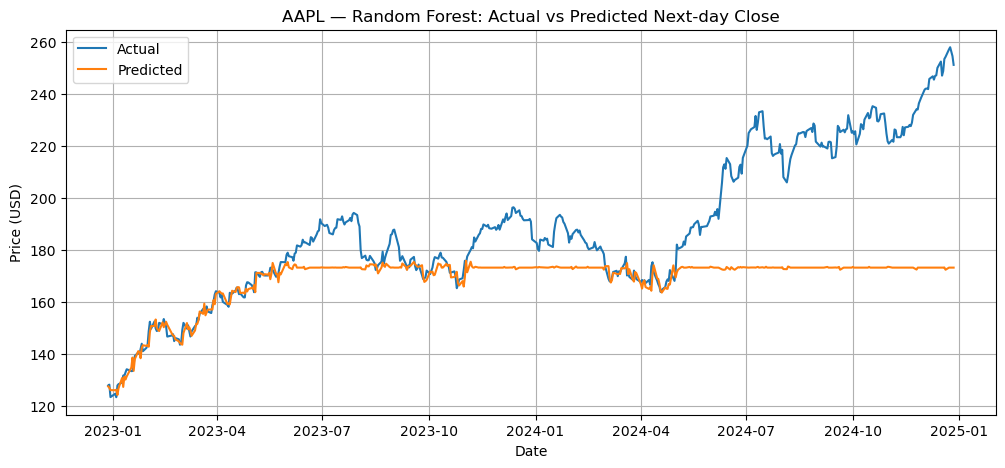

In [7]:
plt.figure(figsize=(12,5))
plt.plot(results_aapl.index, results_aapl['Actual'], label='Actual')
plt.plot(results_aapl.index, results_aapl['Predicted'], label='Predicted')
plt.title('AAPL — Random Forest: Actual vs Predicted Next-day Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Model — Linear Regression (TSLA)

**Why Linear Regression?**
- Linear Regression is a simple baseline model that assumes a linear relationship between features and target.
- It's fast, interpretable, and often a good baseline to compare against more complex models.

We train a Linear Regression model and evaluate using MAE, RMSE, and R².


In [8]:
# Train Linear Regression for TSLA
lr = LinearRegression()
lr.fit(X_train_tsla, y_train_tsla)

y_pred_tsla = lr.predict(X_test_tsla)

# Evaluation
mae_tsla = mean_absolute_error(y_test_tsla, y_pred_tsla)
mse_tsla = mean_squared_error(y_test_tsla, y_pred_tsla)
rmse_tsla = sqrt(mse_tsla)
r2_tsla = r2_score(y_test_tsla, y_pred_tsla)

print('TSLA - Linear Regression Evaluation:')
print(f'MAE: {mae_tsla:.4f}')
print(f'RMSE: {rmse_tsla:.4f}')
print(f'R2: {r2_tsla:.4f}')

# Show last 8 actual vs predicted values in a table
results_tsla = pd.DataFrame({'Date': y_test_tsla.index, 'Actual': y_test_tsla.values, 'Predicted': y_pred_tsla})
results_tsla = results_tsla.set_index('Date')
results_tsla.tail(8)

TSLA - Linear Regression Evaluation:
MAE: 6.3263
RMSE: 8.9148
R2: 0.9767


,Actual,Predicted
Date,,
2024-12-17,440.130005,467.456852
2024-12-18,436.170013,450.997965
2024-12-19,421.059998,429.181637
2024-12-20,430.600006,436.330901
2024-12-23,462.279999,421.213495
2024-12-24,454.130005,456.725402
2024-12-26,431.660004,454.072949
2024-12-27,417.410004,431.143262


### TSLA — Actual vs Predicted (Linear Regression)

Plot below compares actual next-day close prices to predictions from Linear Regression for the TSLA test period.


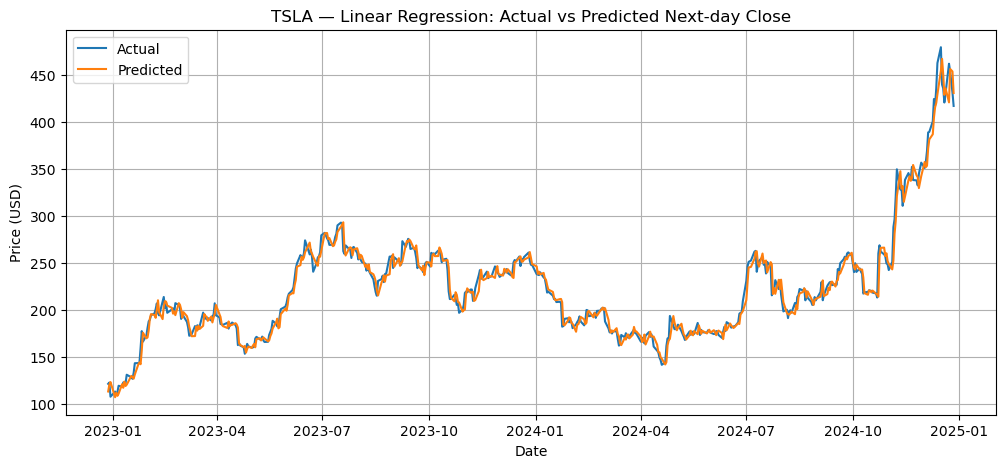

In [9]:
plt.figure(figsize=(12,5))
plt.plot(results_tsla.index, results_tsla['Actual'], label='Actual')
plt.plot(results_tsla.index, results_tsla['Predicted'], label='Predicted')
plt.title('TSLA — Linear Regression: Actual vs Predicted Next-day Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Model Comparison & Recommendations

- **Evaluation metrics** shown above (MAE, RMSE, R²) indicate model performance on the test sets.
- If R² is low or predictions are poor, consider adding features:
  - Lag features (previous day's close, returns)
  - Technical indicators (moving averages, RSI, MACD)
  - Volume-related features (volume change)
- For better sequence modeling, consider time-series-specific models (ARIMA, LSTM).

### Reproducibility & Submission Files

- `prepared` copies of the prepared datasets can be saved if needed using `df.to_csv()`.
- Save trained models with `joblib` if you want to reuse them without retraining.



In [11]:
# Optional: save prepared datasets for submission
try:
    aapl_df.to_csv('/document/aapl_prepared_task2.csv', index=True)
    tsla_df.to_csv('/document/tsla_prepared_task2.csv', index=True)
    print('Saved prepared CSVs to /mnt/data/')
except Exception as e:
    print('Could not save to /mnt/data/ — working directory may be different. Error:', e)

Could not save to /mnt/data/ — working directory may be different. Error: Cannot save file into a non-existent directory: '\document'
